# Google Colab Lab Assignment 5.1 - Forecasting using LSTM

**Course Name:** PEC Deep Learning

**Lab Title:** To forecast future values of a univariate time series using LSTM-based models.

**Student Name:** Harshad Jadhav

**Student ID:** 202201040081

**Date of Submission:** 26/04/2025



**Objective**
This project aims to forecast future values of a univariate time series—specifically the “Predicted Values” attribute from a Stock Market dataset for Nifty-50 dataset—using LSTM-based models.




## Importing required libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(42)


## Data Loading and Exploration

In [4]:
# Load dataset
df = pd.read_csv('/content/NIFTY 50-26-04-2024-to-26-04-2025.csv')

# Display the basic information
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             248 non-null    object 
 1   Open             248 non-null    float64
 2   High             248 non-null    float64
 3   Low              248 non-null    float64
 4   Close            248 non-null    float64
 5   Shares Traded    248 non-null    int64  
 6   Turnover (₹ Cr)  248 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 13.7+ KB
None


In [5]:
df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
0,26-APR-2024,22620.40,22620.40,22385.55,22419.95,329887340,36984.89
1,29-APR-2024,22475.55,22655.80,22441.90,22643.40,291957361,32431.45
2,30-APR-2024,22679.65,22783.35,22568.40,22604.85,361859375,38741.70
3,02-MAY-2024,22567.85,22710.50,22567.85,22648.20,445909456,43133.31
4,03-MAY-2024,22766.35,22794.70,22348.05,22475.85,438060727,44432.55


In [8]:
# Check for the exact column name
print(df.columns)

# Strip any extra spaces from column names
df.columns = df.columns.str.strip()

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')

# Sort by Date
df.sort_values(by='Date', inplace=True)

# Drop missing values
df.dropna(inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)


Index(['Date ', 'Open ', 'High ', 'Low ', 'Close ', 'Shares Traded ',
       'Turnover (₹ Cr)'],
      dtype='object')


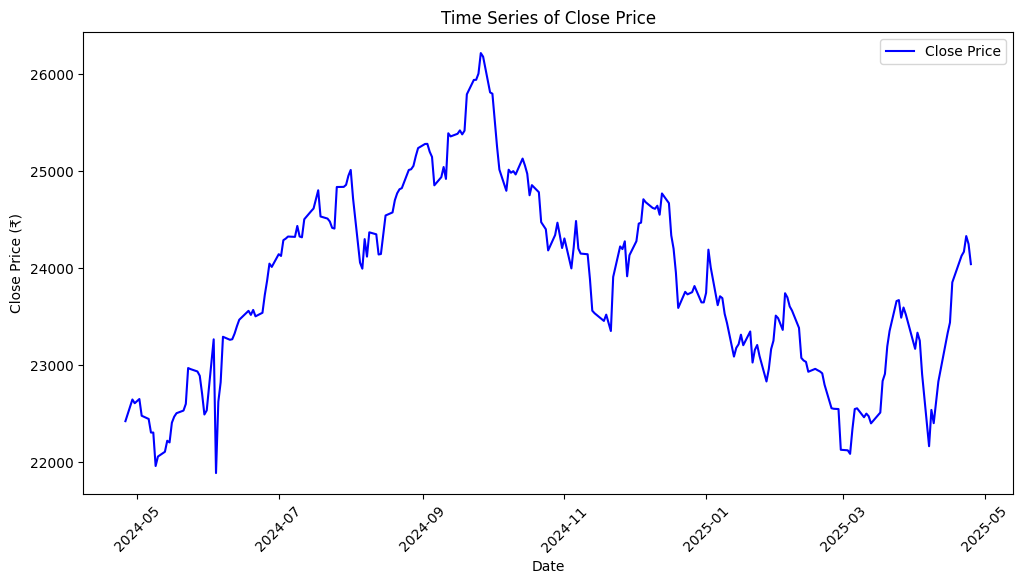

In [9]:
import matplotlib.pyplot as plt

# Prepare the time series with 'Date' as index and 'Close' price for visualization
time_series = df[['Date', 'Close']].copy()
time_series.set_index('Date', inplace=True)

# Visualize the time series
plt.figure(figsize=(12, 6))
plt.plot(time_series.index, time_series['Close'], label='Close Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price (₹)')
plt.title('Time Series of Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()


## Data Normalization

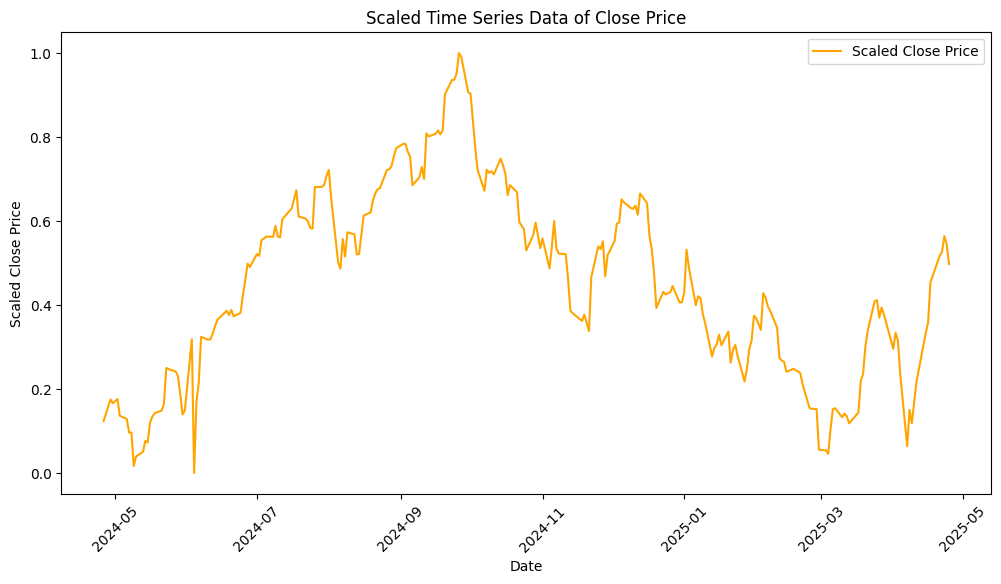

In [10]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'Close' price data
scaled_data = scaler.fit_transform(time_series[['Close']])

# Plot a sample of scaled data
plt.figure(figsize=(12, 6))
plt.plot(time_series.index, scaled_data, label='Scaled Close Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Scaled Close Price')
plt.title('Scaled Time Series Data of Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()


## Create Sequences with Window Size 60

In [11]:
import numpy as np

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])  # Previous 'window_size' data points
        y.append(data[i, 0])  # The next value after the window
    return np.array(X), np.array(y)

# Define the window size for creating sequences
window_size = 60

# Create sequences from the scaled data (using 'Close' prices)
X, y = create_sequences(scaled_data, window_size)

# Reshape the input data for LSTM: (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Print the shape of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (188, 60, 1)
Shape of y: (188,)


## Split Data into Training and Testing Sets

In [12]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (150, 60, 1)
Shape of X_test: (38, 60, 1)


## Build and Train the Standard LSTM Model

In [13]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
lstm_model.summary()

# Define callbacks: EarlyStopping and ModelCheckpoint
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
mc = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history_lstm = lstm_model.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              validation_split=0.1,
                              callbacks=[es, mc],
                              verbose=1)


Epoch 1/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0137
Epoch 1: val_loss did not improve from 0.00723
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0130 - val_loss: 0.0075
Epoch 2/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0163
Epoch 2: val_loss did not improve from 0.00723
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0155 - val_loss: 0.0092
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0089
Epoch 3: val_loss did not improve from 0.00723
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0124 - val_loss: 0.0109
Epoch 4/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0131
Epoch 4: val_loss did not improve from 0.00723
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0140 - val_loss: 0.0110
Epoch 5/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0112
Epoch 5: val_loss did not improve from 0.00723
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 6/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0129
Epoch 6: val_loss di

## Evaluate and Plot Predictions for LSTM Model

In [24]:
# LSTM Predictions on test data
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform predictions and true values
lstm_predictions_inv = scaler.inverse_transform(lstm_predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [25]:
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_predictions_inv))
lstm_mae = mean_absolute_error(y_test_inv, lstm_predictions_inv)
print(f"LSTM Test RMSE: {lstm_rmse:.2f}")
print(f"LSTM Test MAE: {lstm_mae:.2f}")


LSTM Test RMSE: 630.21
LSTM Test MAE: 525.58


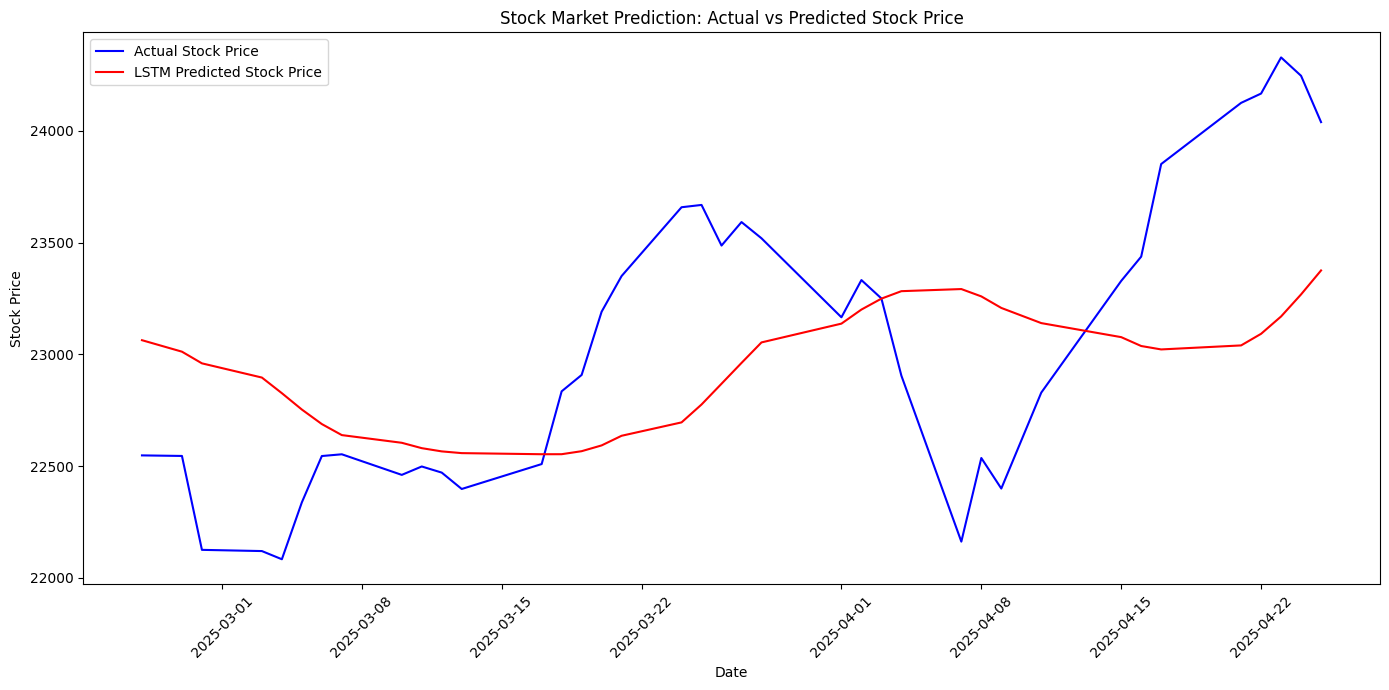

In [26]:

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
lstm_predictions_inv = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))

test_dates = time_series.index[-len(y_test_inv):]

# Plotting the actual vs predicted stock prices
plt.figure(figsize=(14,7))
plt.plot(test_dates, y_test_inv, color='blue', label='Actual Stock Price')  # Actual values
plt.plot(test_dates, lstm_predictions_inv, color='red', label='LSTM Predicted Stock Price')  # Predicted values
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Market Prediction: Actual vs Predicted Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Build and Train a Bidirectional LSTM (BiLSTM) Model

In [27]:
# Define the Bidirectional LSTM model
bilstm_model = Sequential()
# First layer: Bidirectional LSTM with dropout
bilstm_model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
bilstm_model.add(Dropout(0.2))
# Second layer: Standard LSTM
bilstm_model.add(LSTM(units=50, return_sequences=False))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(1))

bilstm_model.compile(optimizer='adam', loss='mean_squared_error')
bilstm_model.summary()

# Callbacks: EarlyStopping and ModelCheckpoint for BiLSTM
es_bi = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
mc_bi = ModelCheckpoint('best_bilstm_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 100)        │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history_bilstm = bilstm_model.fit(X_train, y_train,
                                  epochs=50,
                                  batch_size=32,
                                  validation_split=0.1,
                                  callbacks=[es_bi, mc_bi],
                                  verbose=1)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0200
Epoch 1: val_loss did not improve from 0.00558
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0198 - val_loss: 0.0115
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0134 
Epoch 2: val_loss did not improve from 0.00558
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0135 - val_loss: 0.0182
Epoch 3/50
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0156 
Epoch 3: val_loss did not improve from 0.00558
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0152 - val_loss: 0.0098
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0143
Epoch 4: val_loss did not improve from 0.00558
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0141 - val_loss: 0.0068
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0150
Epoch 5: val_loss did not improve from 0.00558
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0149 - val_loss: 0.0081
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0123 
Epoch 6: val_loss 

## Evaluate and Plot Predictions for BiLSTM Model

In [37]:
# BiLSTM Predictions on test data
bilstm_predictions = bilstm_model.predict(X_test)

# Inverse transform predictions and the true values
bilstm_predictions_inv = scaler.inverse_transform(bilstm_predictions)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [35]:
bilstm_rmse = np.sqrt(mean_squared_error(y_test_inv, bilstm_predictions_inv))
bilstm_mae = mean_absolute_error(y_test_inv, bilstm_predictions_inv)
print(f"BiLSTM Test RMSE: {bilstm_rmse:.2f}")
print(f"BiLSTM Test MAE: {bilstm_mae:.2f}")


BiLSTM Test RMSE: 582.40
BiLSTM Test MAE: 498.84


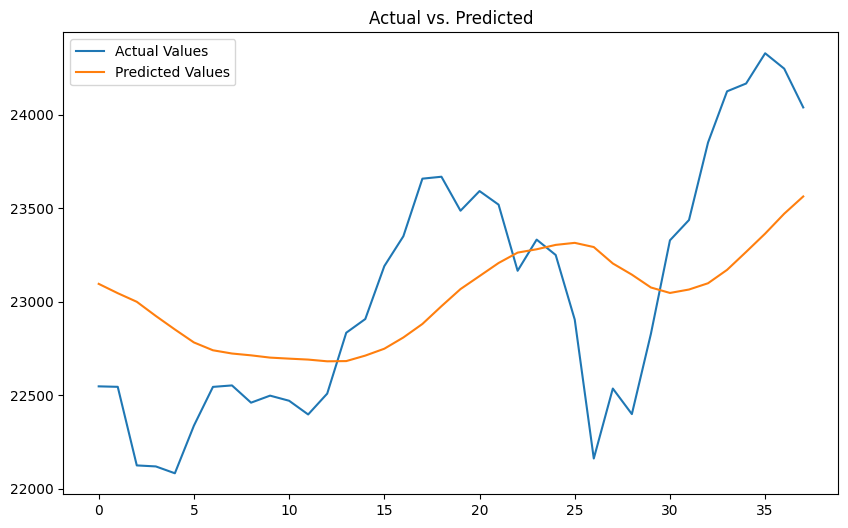

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Values')
plt.plot(bilstm_predictions_inv, label='Predicted Values')
plt.legend()
plt.title('Actual vs. Predicted')
plt.show()


### **Declaration**

I, Harshad Jadhav, confirm that the work submitted in this assignment is my own and has been completed following academic integrity guidelines. The code is uploaded on my GitHub repository account, and the repository link is provided below:

GitHub Repository Link: https://github.com/Harshad071/Deep_Learning_Assignment_5.1

Signature: Harshad Manoj Jadhav